In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc
import os, time
from IPython.display import display, clear_output

In [2]:
sample_rate = 4096
duration = 6.
dt=1./sample_rate

f0 = 40.
f_low = 40.
f_high =  2048.
df = 1.
m1_min = 10.
m1_max = 50.
m2_min = 10.
m2_max = 50.

min_match = 0.99
filter_cutoff = 'SchwarzISCO'
psd_model = 'aLIGODesignSensitivityP1200087'

outfile='template_bank.xml'
template_file='templates'
signal_file='signal'

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")
strain = merger.strain('H1')

strain = resample_to_delta_t(highpass(strain, f_low), dt)

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = strain.crop(14, 15)
psd = conditioned.psd(1)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(sample_rate),
                                  low_frequency_cutoff=f_low)

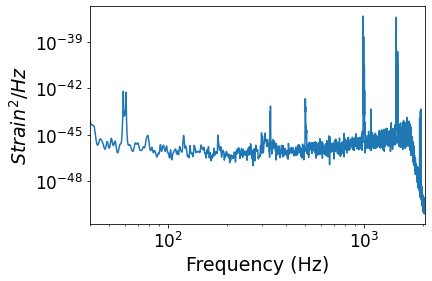

In [5]:
plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(f_low, f_high)
plt.show()

In [6]:
datafreq = np.fft.fftfreq(len(conditioned))*sample_rate
psd_ = np.interp(datafreq, np.array(psd.sample_frequencies), np.array(psd))

In [7]:
if not os.path.isfile(outfile):
    !echo "pycbc_geom_nonspinbank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model}"
    !pycbc_geom_nonspinbank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model}

In [8]:
from pycbc.waveform.bank import TemplateBank

waveforms = TemplateBank(outfile)

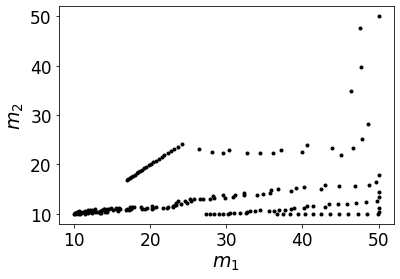

In [9]:
%matplotlib inline

plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

In [10]:
m1s = waveforms.table['mass1']
m2s = waveforms.table['mass2']
s1s = waveforms.table['spin1z']
s2s = waveforms.table['spin2z']

In [11]:
from pycbc.waveform import get_td_waveform

templates = []
hps = []

if True:
    i=0
    for m1,m2,s1,s2 in zip(m1s,m2s,s1s,s2s):
        clear_output(wait=True)
        display("Generated template "+str(i+1)+" of "+str(len(m1s))+"...")
        waveform = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=float(m1),
                                 mass2=float(m2),
                                 spin1z=float(s1),
                                 spin2z=float(s2),
                                 delta_t=dt,
                                 f_lower=f_low)
        waveform[0].resize(len(conditioned))
        hps.append(waveform[0])
        fhp = np.fft.fft(np.array(waveform[0]))
        sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
        norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
        templates.append((fhp/psd_)*norm)
        i+=1

    templates = np.array(templates)
    np.save(template_file,templates)
    print('Done!')

'Generated template 190 of 190...'

Done!


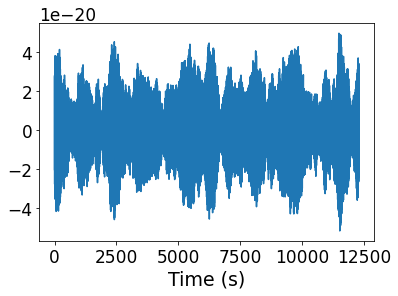

In [12]:
plt.plot(conditioned)
plt.xlabel('Time (s)')
plt.show()

In [13]:
def my_matched_filter(data, template):
    return data*template.conjugate()

In [14]:
signal = np.fft.fft(np.array(conditioned))
np.save(signal_file,signal)

In [15]:
SNRs = []

low_cut = 1
high_cut = 1

for template in templates:
    snr = np.fft.ifft(my_matched_filter(signal,template))
    SNRs.append(np.max(np.abs(snr)[low_cut*sample_rate:-high_cut*sample_rate]))
    
SNRs = np.array(SNRs)

In [16]:
SNR_threshold=18.

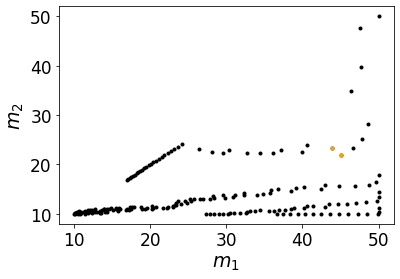

In [17]:
%matplotlib inline

plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
plt.scatter(waveforms.table['mass1'][SNRs>SNR_threshold],waveforms.table['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

In [18]:
max_ind = np.argmax(SNRs)
print(waveforms.table['mass1'][max_ind],waveforms.table['mass2'][max_ind])

45.065193 21.942947
